#Bai 1



## a. [Optional] Implement lại word2vec và train thử với 1 tập dataset bất kì


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import random
import matplotlib.pyplot as plt
import numpy as np

from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
corpus =[
    "I love natural language processing",
    "Deep learning is fun and exciting",
    "Word2Vec learns word embeddings",
    "I enjoy natural language processing techniques"
]

In [ ]:
def tokenize_corpus(corpus):
    tokens = [sentecne.lower().split() for sentecne in corpus]
    return tokens


In [ ]:
tokens = tokenize_corpus(corpus)
print(tokens)

[['i', 'love', 'natural', 'language', 'processing'], ['deep', 'learning', 'is', 'fun', 'and', 'exciting'], ['word2vec', 'learns', 'word', 'embeddings'], ['i', 'enjoy', 'natural', 'language', 'processing', 'techniques']]


In [ ]:
def build_vocab(tokens):
    word_counter = Counter([word for sentence in tokens for word in sentence])
    vocab = {word: i + 2 for i , (word, _) in enumerate(word_counter.items())}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1
    reverse_vocab = {i: word for word, i in vocab.items()}
    return vocab, reverse_vocab

In [ ]:
print(build_vocab(tokens))

({'i': 2, 'love': 3, 'natural': 4, 'language': 5, 'processing': 6, 'deep': 7, 'learning': 8, 'is': 9, 'fun': 10, 'and': 11, 'exciting': 12, 'word2vec': 13, 'learns': 14, 'word': 15, 'embeddings': 16, 'enjoy': 17, 'techniques': 18, '<pad>': 0, '<unk>': 1}, {2: 'i', 3: 'love', 4: 'natural', 5: 'language', 6: 'processing', 7: 'deep', 8: 'learning', 9: 'is', 10: 'fun', 11: 'and', 12: 'exciting', 13: 'word2vec', 14: 'learns', 15: 'word', 16: 'embeddings', 17: 'enjoy', 18: 'techniques', 0: '<pad>', 1: '<unk>'})


In [ ]:
def generate_training_data(tokens, vocab, window_size=2):
    '''
    generate training data for word2vec model
    each word in the corpus is treated as a target, and its surrounding words within a specified window size are considered as context words
    '''
    data = []
    for sentence in tokens:
        sentence_len = len(sentence)
        for idx, word in enumerate(sentence):
            target = vocab.get(word, vocab['<unk>'])
            start = max(0, idx - window_size)
            end = min(sentence_len, idx + window_size + 1)
            context = [vocab.get(sentence[i], vocab['<unk>']) for i in range(start, end) if i != idx]
            while len(context) < 2 * window_size:
              context.append(vocab['<pad>'])
            data.append((target, context))
    return data


In [ ]:
def shuffle_data(data):
    return random.shuffle(data)

In [ ]:
tokens = tokenize_corpus(corpus)
vocab, reverse_vocab = build_vocab(tokens)
data = generate_training_data(tokens, vocab)
shuffle_data(data)

In [ ]:
print(vocab)

{'i': 2, 'love': 3, 'natural': 4, 'language': 5, 'processing': 6, 'deep': 7, 'learning': 8, 'is': 9, 'fun': 10, 'and': 11, 'exciting': 12, 'word2vec': 13, 'learns': 14, 'word': 15, 'embeddings': 16, 'enjoy': 17, 'techniques': 18, '<pad>': 0, '<unk>': 1}


In [ ]:
# define CBOW model
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        x = self.embeddings(x).mean(dim=0)
        x = self.linear(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
model = CBOW(vocab_size=len(vocab), embedding_dim=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#training loop
losses = []
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0
    for target, context in data:
        context = torch.tensor(context, dtype=torch.long).to(device)
        target = torch.tensor(target, dtype=torch.long).to(device)

        optimizer.zero_grad()
        output = model(context)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(data):.4f}')
    losses.append(running_loss / len(data))




Epoch [10/100], Loss: 1.5430
Epoch [20/100], Loss: 0.8254
Epoch [30/100], Loss: 0.5078
Epoch [40/100], Loss: 0.3612
Epoch [50/100], Loss: 0.2856
Epoch [60/100], Loss: 0.2423
Epoch [70/100], Loss: 0.2152
Epoch [80/100], Loss: 0.1973
Epoch [90/100], Loss: 0.1847
Epoch [100/100], Loss: 0.1757


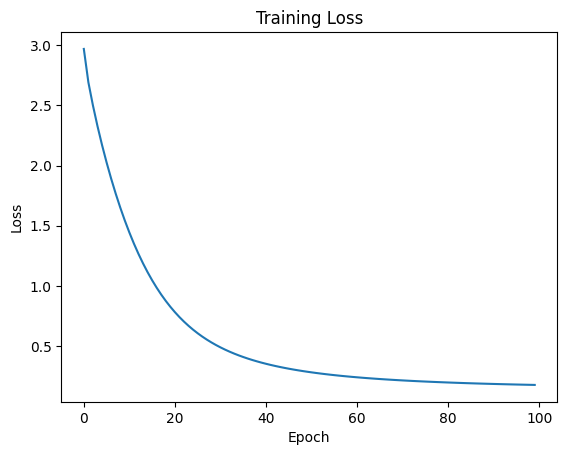

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
word = 'natural'
word_idx = vocab[word]
word_vector = model.embeddings.weight[word_idx].detach().numpy()
print(f"Word: {word}")
print(f"Word Vector: {word_vector}")

Word: natural
Word Vector: [ 2.0386395e+00  5.0859028e-01 -1.9190171e+00  2.9108121e+00
  1.1102475e+00 -6.0060614e-01  2.2503698e+00 -1.2228458e+00
  2.0400770e-02  6.4534955e-02 -2.2977360e-01 -3.7077302e-01
 -3.6864948e-01  1.2975644e+00 -3.4249318e-01 -1.5314306e-01
  1.6919762e-01 -8.7006927e-01 -4.0994391e-01  3.5177252e-01
  6.3275498e-01  5.3419948e-01 -2.0149000e-01  2.8790814e-01
 -9.4638404e-04  5.2555400e-01  1.1831491e+00 -8.9589834e-01
 -2.0095103e+00 -1.0878379e+00  2.2240667e-01 -6.7874476e-02
  9.5826876e-01 -1.8122805e+00 -1.5359463e-01  9.0245557e-01
  1.3031346e+00 -3.6382398e-01 -1.0665417e+00 -3.5285109e-01
 -1.0711072e-01 -2.8911725e-01  1.5073568e+00  1.8708676e+00
 -9.3401223e-01  1.5787066e+00  6.7401439e-01  8.8894415e-01
 -5.6347486e-02  5.4257447e-01 -8.9676070e-01  9.2373770e-01
  5.2183872e-01  1.0802482e+00 -5.5785269e-01 -8.5294992e-01
 -1.3903321e+00  1.1556760e+00  5.6013751e-01  1.2770655e+00
  9.0668029e-01  1.1000109e+00 -8.8022780e-01 -1.3268102e+

In [ ]:
def find_similar_words(word, model, vocab, reverse_vocab, top_n=5):
    """Find top N most similar words based on cosine similarity."""
    word_index = vocab[word]  # Lấy chỉ số của từ
    word_vector = model.embeddings.weight[word_index].detach()  # Lấy vector từ
    all_vectors = model.embeddings.weight.detach()  # Lấy toàn bộ ma trận embedding


    cos_similarities = torch.nn.functional.cosine_similarity(word_vector.unsqueeze(0), all_vectors, dim=1)


    cos_similarities[word_index] = float('-inf')
    for token in ['<pad>', '<unk>']:
        if token in vocab:
            cos_similarities[vocab[token]] = float('-inf')


    top_indices = torch.topk(cos_similarities, top_n).indices
    similar_words = [(reverse_vocab[idx.item()], cos_similarities[idx].item()) for idx in top_indices]

    return similar_words


In [ ]:
similar_words = find_similar_words("natural", model, vocab, reverse_vocab)
print(f"Top similar words to 'natural': {similar_words}")


Top similar words to 'natural': [('love', 0.15383829176425934), ('deep', 0.10617980360984802), ('techniques', 0.08631585538387299), ('exciting', 0.08183664828538895), ('processing', 0.0713239312171936)]


##b. Visualize 1 số tính chất của word2vec, (ví dụ từ đồng nghĩa thì sẽ có embedding gần nhau)

In [ ]:
#set random seed
random.seed(42)
np.random.seed(42)

In [ ]:
#data generate by GPT
sentences = [

    ['king', 'queen', 'man', 'woman', 'royal', 'crown', 'castle'],
    ['queen', 'princess', 'prince', 'kingdom'],
    ['king', 'woman', 'princess', 'heir'],


    ['cat', 'dog', 'animal', 'pet', 'puppy', 'kitten'],
    ['dog', 'bark', 'pet', 'loyal'],
    ['cat', 'meow', 'cute', 'pet'],


    ['apple', 'orange', 'banana', 'fruit', 'fresh', 'mango'],
    ['fruit', 'vitamin', 'delicious', 'apple'],
    ['banana', 'yellow', 'fruit'],


    ['car', 'bus', 'train', 'vehicle', 'transport', 'drive'],
    ['bus', 'stop', 'vehicle', 'driver'],
    ['car', 'electric', 'fast', 'engine'],


    ['man', 'driver', 'engine', 'transport'],
    ['woman', 'dog', 'apple', 'pet'],
    ['train', 'king', 'royal', 'vehicle']
]

group_definitions = {
    "royal":    ["king", "queen", "man", "woman", "royal", "crown", "castle",
                 "princess", "prince", "kingdom", "heir"],
    "animals":  ["cat", "dog", "animal", "pet", "puppy", "kitten", "bark",
                 "loyal", "meow", "cute"],
    "fruits":   ["apple", "orange", "banana", "fruit", "fresh", "mango",
                 "vitamin", "delicious", "yellow"],
    "vehicles": ["car", "bus", "train", "vehicle", "transport", "drive",
                 "stop", "driver", "electric", "fast", "engine"]
}


group_colors = {
    "royal":    "red",
    "animals":  "green",
    "fruits":   "orange",
    "vehicles": "blue",
    #other
    "others":   "gray"
}

In [ ]:
def get_group(word, group_definitions):
    for group_name, word_list in group_definitions.items():
      if word in word_list:
        return group_name
    return "others"

#training w2v
model = Word2Vec(sentences, vector_size=50, window=3, min_count=1, sg=0, epochs=100, workers=1)

#get word list and vector
words = list(model.wv.index_to_key)
embeddings = np.array([model.wv[word] for word in words])


pca = PCA(n_components=20, random_state=42)
pca_result = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, random_state=42, perplexity=5, learning_rate='auto', n_iter=1000, init="random")
reduced_embeddings = tsne.fit_transform(pca_result)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


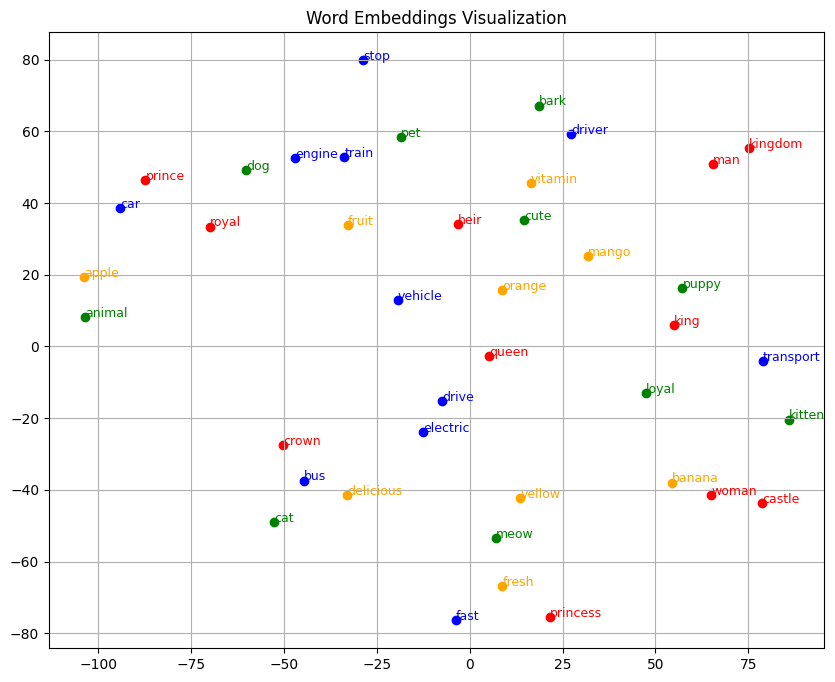

In [ ]:
#visualize
plt.figure(figsize=(10, 8))
for i, word in enumerate(words):
    x, y = reduced_embeddings[i, 0], reduced_embeddings[i, 1]

    g_name = get_group(word, group_definitions)
    color = group_colors.get(g_name, 'gray')

    plt.scatter(x, y, color=color)
    plt.text(x + 0.05, y + 0.05, word, fontsize=9, color=color)

plt.title("Word Embeddings Visualization")
plt.grid(True)
plt.show()

#bài 2 seq2seq

a. đọc hiểu code mẫu và implement transformer cho task dịch thuật

b. implement thuật toán beam search để sinh ra nhiều biến thể của 1 câu

## setting environment due to not match torch vs torchtext

In [ ]:
!pip install -U spacy
!pip install -U portalocker
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uninstalled blis-0.7.11
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.5
    Uninstalling thinc-8.2.5:
      Successfully uninstalled thinc-8.2.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.5
    Uninstalling spacy-3.7.5:
      Successfully uninstalled spacy-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.8.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12

In [ ]:
!pip install --upgrade pip
!pip uninstall -y torch torchtext torchvision torchaudio
!pip install torch==2.0.1 torchtext==0.15.2 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cu118


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 58.4 MB/s eta 0:0

In [ ]:
import torch
import torchtext
print("Torch version:", torch.__version__)
print("Torchtext version:", torchtext.__version__)


Torch version: 2.0.1+cu118
Torchtext version: 0.15.2+cpu


##implement transformer

In [ ]:
#chay rieng do thieu tai nguyen
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math, os
import pandas as pd
import matplotlib.pyplot as plt
import spacy

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch.nn import Transformer

In [ ]:
#set seed and device
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/uploads/eng_-french.csv", usecols=['English words/sentences', 'French words/sentences'])
df.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.1, random_state=seed)
print(f"Train size: {len(train_df)}\nValid size: {len(valid_df)}")

Train size: 158058
Valid size: 17563


In [ ]:
#create dataset
class TranslationDataset(Dataset):
    def __init__(self, df, src_col="English words/sentences", tgt_col="French words/sentences"):
        self.df = df.reset_index(drop=True)
        self.src_col = src_col
        self.tgt_col = tgt_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        src = row[self.src_col]
        tgt = row[self.tgt_col]
        return src, tgt

In [ ]:
train_dataset = TranslationDataset(train_df)
valid_dataset = TranslationDataset(valid_df)

print("sample: {}".format(train_dataset[0]))

sample: ('They kept him waiting outside for a long time.', 'Ils le firent poireauter dehors.')


In [ ]:
# build vocab and tokenizer

#define token_transform (spacy)
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'fr'

token_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='fr_core_news_sm')

In [ ]:
#build vocab with build_vocab_from_iterator

unk_idx, pad_idx, bos_idx, eos_idx = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

vocab_transform = {}

def yield_tokens(dataset, language):
  """
  tra ve danh sach cac token cho tung cau trong dataset, de build vocab cho moi ngon ngu
  """
  index = 0 if language == SRC_LANGUAGE else 1
  for src_text, tgt_text in dataset:
    text = src_text if index == 0 else tgt_text
    yield token_transform[language](text) # token hoa = spacy

#build vocab cho ca 2 ngon ngu
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab = build_vocab_from_iterator(
      yield_tokens(train_dataset, ln),
      min_freq=1, #tu xuat hien >=1 lần thì cho vào vocab
      specials=special_symbols, #thêm token đặc biệt
      special_first=True #cho token đặc biệt ở đầu
  )
  vocab.set_default_index(unk_idx) # neu tu khong co thi tra ve <unk>
  vocab_transform[ln] = vocab

print("english vocab size", len(vocab_transform[SRC_LANGUAGE]))
print("french vocab size", len(vocab_transform[TGT_LANGUAGE]))


english vocab size 15389
french vocab size 25319


In [ ]:
#create function text_transform (token -> ids -> thêm <bos>, <eos>)
def tensor_transform(token_ids):
  """
  thêm BOS, EOS rồi chuyển list token_id thành 1 tensor
  """
  return torch.cat([
      torch.tensor([bos_idx], dtype=torch.long),
      torch.tensor(token_ids, dtype=torch.long),
      torch.tensor([eos_idx], dtype=torch.long)
  ])

def sequential_transform(*transforms):
  """
  ket hop nhieu ham transform lien tiep vao 1 pipeline
  """
  def func(txt_input):
    for transform in transforms:
      txt_input = transform(txt_input)
    return txt_input
  return func

text_transform = {}

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # mooi ngon ngu co 1 pipeline: tokenize -> vocab -> them bos/eos
  text_transform[ln] = sequential_transform(
      token_transform[ln], #tokenize (spacy)
      vocab_transform[ln], #chuyen token -> index
      tensor_transform     # them bos/eos
  )

In [ ]:
#Define collate_fn and dataloader

def collate_fn(batch, text_transform=text_transform):
  """
  collate_fn sẽ được dataloader call để tạo 1 batch
  - batch: list cacs (src_text, tgt_text)
  - text_transform: dictionary hàm transform (ANH, PHÁP)
  """
  src_batch, tgt_batch = [], []

  for src_sample, tgt_sample in batch:
    # apply transform
    src_tensor = text_transform[SRC_LANGUAGE](src_sample)
    tgt_tensor = text_transform[TGT_LANGUAGE](tgt_sample)
    src_batch.append(src_tensor)
    tgt_batch.append(tgt_tensor)

  #pad sequence theo chieu dai max trong batch, dung <pad>
  src_batch = pad_sequence(src_batch, batch_first=True, padding_value=pad_idx)
  tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=pad_idx)

  return src_batch, tgt_batch

batch_size = 64

#create dataloader for tran and valid
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

print("train dataloader size: {}".format(len(train_dataloader)))
print("valid dataloader size: {}".format(len(valid_dataloader)))

train dataloader size: 2470
valid dataloader size: 275


### build Transfomer model

#### a. create supports func: mask, positionalEncoding, tokenembedding

In [ ]:
#create supports func : mask, positionalEncoding, tokenembedding

def generate_square_subsequent_mask(sz):
  """
  create 1 matrix mask tam giac size=sz x sz
  de mo minh encoder cannot see (feature words)
  """
  mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
  # vi tri 0 -> 1 allowed, 1 -> -inf
  mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
  return mask

def create_mask(src, tgt):
    """
    Tạo src_mask, tgt_mask, src_padding_mask, tgt_padding_mask
    - src_mask: cho encoder (ở đây = zeros)
    - tgt_mask: look-ahead mask (tam giác trên)
    - src_padding_mask: True tại vị trí <pad> của src
    - tgt_padding_mask: True tại vị trí <pad> của tgt
    """
    src_seq_len = src.size(1)
    tgt_seq_len = tgt.size(1)

    #tgt_mask: tam giac
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)

    #src_mask: zeros ( enncoder ko can look-ahead)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).bool().to(device)

    #padding mask
    src_padding_mask = (src == pad_idx)
    tgt_padding_mask = (tgt == pad_idx)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
class PositionalEncoding(nn.Module):
  """
  thêm thông tin vị trí cho token embeddings
  theo công thức sin/cos trong paper "Attention is all you need"
  """
  def __init__(self, d_model, dropout=0.1, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    # pe shape: (1, max_len, d_model)
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1).float() #shape (max_len,1)
    div_term = torch.exp(
        -math.log(10000.0)*torch.arange(0, d_model, 2).float()/d_model
    )
    pe[:, 0::2] = torch.sin(position*div_term)
    pe[:, 1::2] = torch.cos(position*div_term)
    pe = pe.unsqueeze(0) # shape (1, max_len, d_model)

    self.register_buffer('pe', pe) #kp tham so train

  def forward(self, x):
    """
    x: shape (batch_size, seq_len, d_model)
    """
    x = x + self.pe[:, :x.size(1),:].to(device)
    return self.dropout(x)

In [ ]:
class TokenEmbedding(nn.Module):
  """
  tra cu emmbedding cho moi token_id, roi scale boi sqrt(d_model)
  """
  def __init__(self, vocab_size, emb_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, emb_size)
    self.emb_size = emb_size

  def forward(self, tokens):
    #tokens shape: (batch, seq_len)
    #output shape: (batch, seq_len, emb_size)
    return self.embedding(tokens.long())*math.sqrt(self.emb_size)

#### Seq2SeqTransformer (encoder-decoder)

In [ ]:
class Seq2SeqTransformer(nn.Module):
  """
  architecture encoder-decoder trnsfomer
  """
  def __init__(
      self,
      num_encoder_layers: int,
      num_decoder_layers: int,
      emb_size: int,
      nhead: int,
      src_vocab_size: int,
      tgt_vocab_size: int,
      dim_feedforward: int = 512,
      dropout=0.1
  ):
    super(Seq2SeqTransformer, self).__init__()

    #lop transformer available: batch_first=True => (batch, seq, dim)
    self.transformer = Transformer(
        d_model=emb_size,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
        batch_first=True
    )

    # lop linear cuooi cung de chuyen hidden state => du doan token
    self.generator = nn.Linear(emb_size, tgt_vocab_size)

    # embedding for src and tgt
    self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
    self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)

    #positional encoding
    self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

  def forward(
      self,
      src,
      tgt,
      src_mask,
      tgt_mask,
      src_padding_mask,
      tgt_padding_mask,
      memory_key_padding_mask
  ):
      """
        src, tgt shape: (batch, seq_len)
        - src_mask, tgt_mask: look-ahead mask
        - src_padding_mask, tgt_padding_mask: mask <pad>
        - memory_key_padding_mask: mask <pad> cho memory (kết quả encoder)
        Output shape: (batch, tgt_seq_len, tgt_vocab_size)
      """
      # them embedding + positional encoding
      src_emb = self.positional_encoding(self.src_tok_emb(src))
      tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))

      #transformer foward
      outs = self.transformer(
          src_emb, #(batch, src_len, emb_size)
          tgt_emb, #(batch, tgt_len, emb_size)
          src_mask, #(src_len, src_Len)
          tgt_mask, #(tgt_len, tgt_len)
          None, # coss attention mask (optional)
          src_padding_mask, #(batch, src_len)
          tgt_padding_mask, #(batch, tgt_len)
          memory_key_padding_mask
      )
      #outs shape: (batch, tgt_len, emb_size)
      #generator -> (batch, tgt_len, tgt_vocab_size)
      return self.generator(outs)

  def encode(self, src, src_mask):
    """
    encoder src -> memory, thuong` dung` cho inference
    """
    return self.transformer.encoder(
        self.positional_encoding(self.src_tok_emb(src)),
        src_mask
    )

  def decode(self, tgt, memory, tgt_mask):
    """
    decode and memory from encode -> return back hidden state (haven't linear yet)
    """
    return self.transformer.decoder(
        self.positional_encoding(self.tgt_tok_emb(tgt)),
        memory,
        tgt_mask
    )

### Training and Evaluate

In [ ]:
# hyperparameters
num_encoder_layers = 3
num_decoder_layers = 3
emb_size = 192
nhead = 6
ffn_hid_dim = 256
epochs = 10
lr = 1e-4

src_vocab_size = len(vocab_transform[SRC_LANGUAGE])
tgt_vocab_size = len(vocab_transform[TGT_LANGUAGE])

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    emb_size=emb_size,
    nhead=nhead,
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    dim_feedforward=ffn_hid_dim,
    dropout=0.1
).to(device)

# loss func ko tinh loss cua token <pad>
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)

#optim adam
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

print("Total model parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total model parameters: 14635559
Trainable parameters: 14635559


In [ ]:
# def train and evaluate

def train_epoch(model, optimizer):
    """
    1 epoch: chạy qua train_loader,
    - Tính loss
    - backward + step optimizer
    - trả về loss trung bình
    """
    model.train()
    total_loss = 0

    for src,tgt in tqdm(train_dataloader, desc="Training", leave=False):
      #src, tgt shape : (batch, seq_len)
      src, tgt = src.to(device), tgt.to(device)

      #tgt_input (bo token cuoi), tgt_out(bo token dau)
      tgt_input = tgt[:, :-1]
      tgt_out = tgt[:, 1:]

      #tao mask
      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
      optimizer.zero_grad()

      #forward
      logits = model(
          src,
          tgt_input,
          src_mask,
          tgt_mask,
          src_padding_mask,
          tgt_padding_mask,
          src_padding_mask
      )
      #logits shape: (batch, seq_len, tgt_vocab_size)

      #tinh loss so sanh voi tgt_out
      loss = loss_fn(
          logits.reshape(-1, logits.shape[-1]), # => (batch*seq, vocab_size)
          tgt_out.reshape(-1) # => (batch*seq)
      )
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
    return total_loss / len(train_dataloader)

def evaluate(model):
  """
  tinh loss tren valid_loader, ko backpopagation
  """
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for src, tgt in tqdm(valid_dataloader, desc="Validating", leave=False):
      src, tgt = src.to(device), tgt.to(device)
      tgt_input = tgt[:, :-1]
      tgt_out = tgt[:, 1:]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
      logits = model(
          src,
          tgt_input,
          src_mask,
          tgt_mask,
          src_padding_mask,
          tgt_padding_mask,
          src_padding_mask
      )
      loss = loss_fn(
          logits.reshape(-1, logits.shape[-1]),
          tgt_out.reshape(-1)
      )
      total_loss += loss.item()
  return total_loss / len(valid_dataloader)


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validating:   0%|          | 0/275 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Epoch: 1, Train loss: 4.5383, Valid loss: 3.5502


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Validating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 2, Train loss: 3.4166, Valid loss: 3.0192


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Validating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 3, Train loss: 3.0232, Valid loss: 2.7056


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Validating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 4, Train loss: 2.7585, Valid loss: 2.4849


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Validating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 5, Train loss: 2.5576, Valid loss: 2.3114


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Validating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 6, Train loss: 2.4024, Valid loss: 2.1900


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Validating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 7, Train loss: 2.2808, Valid loss: 2.0838


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Validating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 8, Train loss: 2.1798, Valid loss: 1.9995


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Validating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 9, Train loss: 2.0985, Valid loss: 1.9392


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Validating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 10, Train loss: 2.0278, Valid loss: 1.8746


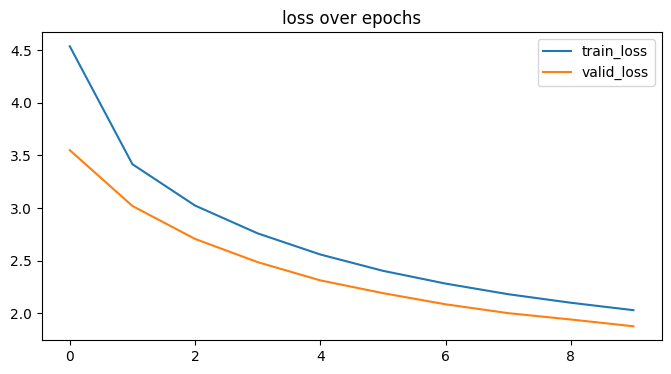

In [ ]:
train_losses, valid_losses = [], []

for epoch in range(1, epochs+1):
  train_loss = train_epoch(model, optimizer)
  valid_loss = evaluate(model)

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  print(f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="train_loss")
plt.plot(valid_losses, label="valid_loss")
plt.legend()
plt.title("loss over epochs")
plt.show()

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
  """
  thuật toán greedy: mỗi bước chọn 1 từ có xác suất cao nhất.
  - src: (1, src_len) (batch=1)
  - src_mask: (src_len, src_len)
  - max_len : giới hạn độ dài
  - start_symbol: token <bos_idx>
  """
  model.eval()

  #memory = result of encoder
  memory = model.encode(src, src_mask)

  # tạo tgt ban đầu chứa duy nhất BOS
  ys= torch.ones(1, 1, device=device).fill_(start_symbol).long()

  for i in range(max_len - 1):
    # tao tgt_mask tam giac cho do dai` hien tai
    tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(device)

    #decode
    out = model.decode(ys, memory, tgt_mask)
    out = model.generator(out[:, -1]) # laay buoc cuoi (shape(1, vocab_size))

    #lay token co xac suat caoa nhat
    _, next_word = torch.max(out,dim=1)
    next_word = next_word.item()

    # noi token vao chuoi tgt
    ys = torch.cat([ys, torch.tensor([[next_word]], device=device)], dim=1)

    # neu gap eos thi dung
    if next_word == eos_idx:
      break # exit the loop when EOS is found
  return ys #return the generated sequence

In [ ]:
#translate func
def translate(model, src_sentence, max_len=50, start_symbol=bos_idx): #set default value for max_len and start_symbol
  """
  nhan cau tieng Anh va tra ve cau tieng Phap
  """
  model.eval()

  # chuoi -> tensor
  src_tensor = text_transform[SRC_LANGUAGE](src_sentence.lower()).unsqueeze(0).to(device)

  #tao src_mask = zeros (vi encoder ko can look-ahead)
  num_tokens = src_tensor.size(1)
  src_mask = torch.zeros((num_tokens, num_tokens), device=device).bool()

  #call greedy_decode with max_len and start_symbol
  tgt_tokens = greedy_decode(model, src_tensor, src_mask, max_len, start_symbol).squeeze(0).cpu().numpy() #add max_len and start_symbol

  #chuyen ids -> token
  return " ".join(
      vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens))
  ).replace("<bos","").replace("<eos>", "").strip()

In [ ]:
#test
test_sentences = [
    "take a seat",
    "I'm not scared to die",
    "The clock has stopped"
]

for s in test_sentences:
  pred = translate(model, s)
  print(f"{s} => {pred}")

take a seat => > Allez un siège
I'm not scared to die => > N' est pas peur de mourir à mourir .
The clock has stopped => > L' avion a arrêté les toilettes .


###implement BearmSearch

In [ ]:
def beam_search_decode(model, src, src_mask, beam_size=5, max_len=50, start_symbol=bos_idx):
  # encode src -> memory
  memory = model.encode(src, src_mask) #shape (B=1, src_len, emb_dim)

  #khoi tao beam contain (sequence, log_prob)
  init_seq = torch.full((1,1), start_symbol, dtype=torch.long, device=src.device)
  beams = [(init_seq, 0.0)]

  # for past max_len
  for step in range(max_len):
    new_beams = []

    for (seq, score) in beams:
      # if seq is over EOS, append to new_beams
      if seq[0, -1] == eos_idx:
        new_beams.append((seq, score))
        continue

      # create tgt_mask
      tgt_mask = generate_square_subsequent_mask(seq.size(1)).to(src.device)

      #decode
      out = model.decode(seq, memory, tgt_mask)
      out = model.generator(out[:, -1]) # get final logits step, shape(1, vocab_size)
      log_probs = torch.log_softmax(out, dim=-1)

      #get top beam_size toke
      top_log_probs, top_ids = torch.topk(log_probs, k=beam_size, dim=-1)

      # create new beam
      for i in range(beam_size):
        token_id = top_ids[0, i].unsqueeze(0).unsqueeze(0)
        new_seq = torch.cat([seq, token_id], dim=1)
        new_score = score + top_log_probs[0, i].item()
        new_beams.append((new_seq, new_score))

    # sort new_beams follow decrease score + cut beam_size
    new_beams.sort(key=lambda x: x[1], reverse=True)
    beams = new_beams[:beam_size]

    #if all beam is over, early break
    all_eos = all(b[0][0, -1] == eos_idx for b in beams)
    if all_eos:
      break

  # chose beam has hightest log_prob
  best_seq, best_score = max(beams, key=lambda x: x[1])
  return best_seq

In [ ]:
def translate_beam(model, src_sentence, beam_size=5, max_len=50):
  model.eval()

  #transform src_sentence -> tensor
  src_tensor = text_transform[SRC_LANGUAGE](src_sentence.lower()).unsqueeze(0).to(device)
  num_tokens = src_tensor.shape[1]
  src_mask = torch.zeros((num_tokens, num_tokens), device=device).bool()

  # call beam_search_decode
  tgt_tokens = beam_search_decode(model, src_tensor, src_mask, beam_size=beam_size, max_len=max_len).squeeze(0).cpu().numpy()

  # id -> token
  return " ".join(
      vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens))
  ).replace("<bos", " ").replace("<eos>", "").strip()

In [ ]:

for s in test_sentences:
  pred = translate_beam(model, s)
  print(f"{s} => {pred}")

take a seat => > Ça va prendre un siège .
I'm not scared to die => > N' aie pas peur de mourir .
The clock has stopped => > L' avion a arrêté .
